In [77]:
%tensorflow_version 1.x

In [78]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [79]:
# !pip install tensorflow==1.14.0

In [80]:
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from tqdm import tqdm
import pandas as pd
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Activation, Flatten, Concatenate
from keras.preprocessing.text import Tokenizer
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
import nltk

In [81]:
# gdrive/My Drive/Image_Captioning/flickr8k/Flickr8k_text
token = 'gdrive/My Drive/Image_Captioning/flickr8k/Flickr8k_text/Flickr8k.token.txt'

captions = open(token, 'r').read().strip().split('\n')

In [82]:
# captions

In [83]:
d = {}
for i, row in enumerate(captions):
    row = row.split('\t')
    row[0] = row[0][:len(row[0])-2]
    if row[0] in d:
        d[row[0]].append(row[1])
    else:
        d[row[0]] = [row[1]]

In [84]:
images = 'gdrive/My Drive/Image_Captioning/flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/'
img = glob.glob(images+'*.jpg')

In [85]:
print ("The total number of images is : ",len(img))
print (img[:10])

The total number of images is :  8127
['gdrive/My Drive/Image_Captioning/flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/3584534971_b44f82c4b9.jpg', 'gdrive/My Drive/Image_Captioning/flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/3338590946_f25b76cbc7.jpg', 'gdrive/My Drive/Image_Captioning/flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/1332823164_c70a5d930e.jpg', 'gdrive/My Drive/Image_Captioning/flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/111497985_38e9f88856.jpg', 'gdrive/My Drive/Image_Captioning/flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/3508522093_51f6d77f45.jpg', 'gdrive/My Drive/Image_Captioning/flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/3030793171_55cd646eed.jpg', 'gdrive/My Drive/Image_Captioning/flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/3285180819_a9712fd2bc.jpg', 'gdrive/My Drive/Image_Captioning/flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/2900274587_f2cbca4c58.jpg', 'gdrive/My Drive/Image_Captioning/flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/2410040397_1a161a1146.jpg', 'gdrive/

In [86]:
def split_data(l):
    temp = []
    for i in img:
        if i[len(images):] in l:
            temp.append(i)
    return temp

In [87]:
##Train file
print("*****************  TRAINING  *****************")
train_images_file = 'gdrive/My Drive/Image_Captioning/flickr8k/Flickr8k_text/Flickr_8k.trainImages.txt'
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))
train_img = split_data(train_images)
print ("The size of the training file is : ",len(train_img))
print ("The sample paths of the images in training set are : ",train_img[:5])

#Validation file
print("*****************  VALIDATION  *****************")
val_images_file = 'gdrive/My Drive/Image_Captioning/flickr8k/Flickr8k_text/Flickr_8k.devImages.txt'
val_images = set(open(val_images_file, 'r').read().strip().split('\n'))
val_img = split_data(val_images)
print ("The size of the validation file is : ",len(val_img))
print ("The sample paths of the images in validation set are : ",val_img[:5])

#Test file
print("*****************  TESTING  *****************")
test_images_file = 'gdrive/My Drive/Image_Captioning/flickr8k/Flickr8k_text/Flickr_8k.testImages.txt'
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))
test_img = split_data(test_images)
print ("The size of the validation file is : ",len(test_img))
print ("The sample paths of the images in testing set are : ",test_img[:5])

*****************  TRAINING  *****************
The size of the training file is :  6000
The sample paths of the images in training set are :  ['gdrive/My Drive/Image_Captioning/flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/3030793171_55cd646eed.jpg', 'gdrive/My Drive/Image_Captioning/flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/3285180819_a9712fd2bc.jpg', 'gdrive/My Drive/Image_Captioning/flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/2410040397_1a161a1146.jpg', 'gdrive/My Drive/Image_Captioning/flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/430964917_022995afb6.jpg', 'gdrive/My Drive/Image_Captioning/flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/2259336826_0cb294e1f7.jpg']
*****************  VALIDATION  *****************
The size of the validation file is :  1000
The sample paths of the images in validation set are :  ['gdrive/My Drive/Image_Captioning/flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/1332823164_c70a5d930e.jpg', 'gdrive/My Drive/Image_Captioning/flickr8k/Flickr8k_Dataset/Flicker8k_Dat

In [88]:
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model

model=InceptionV3(weights='imagenet')
new_input = model.input
hidden_layer = model.layers[-2].output

model_new = Model(new_input, hidden_layer)

In [89]:
def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    x = preprocess_input(x)
    return x

Before Preprocessing : 


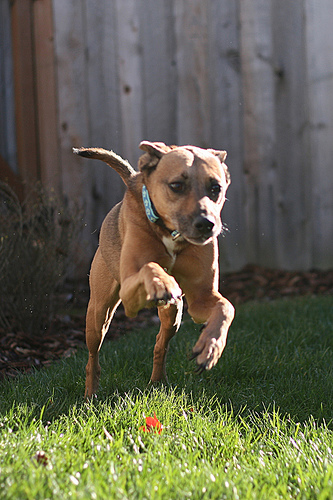

In [90]:
print("Before Preprocessing : ")
Image.open(train_img[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After Preprocessing : 


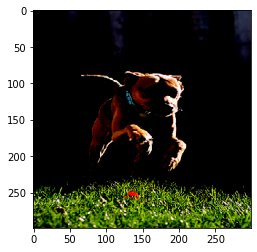

In [91]:
print("After Preprocessing : ")
plt.imshow(np.squeeze(preprocess(train_img[0])))

In [92]:
##try the inception model 
# feature_vec=model_new.predict(preprocess(train_img[0]))
# feature_vec.shape[1]

def encode(image):
    image = preprocess(image)
    temp_enc = model_new.predict(image)
    temp_enc = np.reshape(temp_enc, temp_enc.shape[1])
    return temp_enc

In [93]:
import os 
if not os.path.exists('gdrive/My Drive/Image_Captioning/cap_gen/encoded_images_inceptionV3.p'):
  encoding_train = {}
  for img in tqdm(train_img):
      encoding_train[img[len(images):]] = encode(img)
  
  with open("gdrive/My Drive/Image_Captioning/cap_gen/encoded_images_inceptionV3.p", "wb") as encoded_pickle:
      pickle.dump(encoding_train, encoded_pickle)
else :
  encoding_train = pickle.load(open('gdrive/My Drive/Image_Captioning/cap_gen/encoded_images_inceptionV3.p', 'rb'))

In [94]:
train_d = {}
for i in train_img:
    if i[len(images):] in d:
        train_d[i] = d[i[len(images):]]

In [95]:
 train_d

{'gdrive/My Drive/Image_Captioning/flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/3030793171_55cd646eed.jpg': ['A brown dog is running in a yard .',
  'a brown dog jumping through the grass .',
  'A brown dog runs in the grass with a wooden fence behind .',
  'A dog running in a fenced yard',
  'Brown dog running on grass .'],
 'gdrive/My Drive/Image_Captioning/flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/3285180819_a9712fd2bc.jpg': ['A basketball player in blue is attempting to block a player in white during a game .',
  'The men are playing basketball .',
  'Two basketball players play in a game .',
  'Two black men playing basketball in a gym .',
  'Two men from opposite teams play basketball together .'],
 'gdrive/My Drive/Image_Captioning/flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/2410040397_1a161a1146.jpg': ['A black and brown dog is running through the woods .',
  'A black and brown dog runs through the woods .',
  'A dog running through the woods .',
  'A dog runs through the wood

In [96]:
# print ("The size of the encoded train features(1 image ) : ",encoding_train[train_img[0][len(images):]].shape)
# print ("Caption of the image : ",train_d[images+train_img[0][len(images):]])

In [97]:
import os 
if not os.path.exists('gdrive/My Drive/Image_Captioning/cap_gen/encoded_images_val_inceptionV3.p'):
  encoding_val = {}
  for img in tqdm(val_img):
      encoding_val[img[len(images):]] = encode(img)
  
  with open("gdrive/My Drive/Image_Captioning/cap_gen/encoded_images_val_inceptionV3.p", "wb") as encoded_pickle:
      pickle.dump(encoding_val, encoded_pickle)
else :
  encoding_val = pickle.load(open('gdrive/My Drive/Image_Captioning/cap_gen/encoded_images_val_inceptionV3.p', 'rb'))

In [98]:
val_d = {}
for i in val_img:
    if i[len(images):] in d:
        val_d[i] = d[i[len(images):]]

In [99]:
import os 
if not os.path.exists('gdrive/My Drive/Image_Captioning/cap_gen/encoded_images_test_inceptionV3.p'):
  print("Saving the Inception v3 features for test data")
  encoding_test = {}
  for img in tqdm(test_img):
      encoding_test[img[len(images):]] = encode(img)
  
  with open("gdrive/My Drive/Image_Captioning/cap_gen/encoded_images_test_inceptionV3.p", "wb") as encoded_pickle:
      pickle.dump(encoding_test, encoded_pickle)
else :
  print("Loading the Inception v3 features for test data")
  encoding_test = pickle.load(open('gdrive/My Drive/Image_Captioning/cap_gen/encoded_images_test_inceptionV3.p', 'rb'))

Loading the Inception v3 features for test data


In [100]:
# encoding_test.get('3584534971_b44f82c4b9.jpg').size

In [101]:
test_d = {}
for i in test_img:
    if i[len(images):] in d:
        test_d[i] = d[i[len(images):]]

In [102]:
##Appending the start and end token to the captions 
caps = []
for key, val in train_d.items():
    for i in val:
        caps.append('<start> ' + i + ' <end>')

In [103]:
if not os.path.exists('gdrive/My Drive/Image_Captioning/cap_gen/unique.p'):
  print("Saving the list of Unique Words")

  words = [i.split() for i in caps]
  unique = []
  for i in words:
      unique.extend(i)

  unique=list(set(unique))

  with open("gdrive/My Drive/Image_Captioning/cap_gen/unique.p", "wb") as pickle_d:
      pickle.dump(unique, pickle_d)
else :
  print("Loading the list of Unique Words")
  unique = pickle.load(open('gdrive/My Drive/Image_Captioning/cap_gen/unique.p', 'rb'))

vocab_size=len(unique)
print("The size of the vocabulary is : ",vocab_size)

Loading the list of Unique Words
The size of the vocabulary is :  8256


In [104]:
word2idx = {val:index for index, val in enumerate(unique)}
idx2word = {index:val for index, val in enumerate(unique)}

In [105]:
if not os.path.exists('gdrive/My Drive/Image_Captioning/cap_gen/max_sent_len.pkl'):
    max_len = 0
    for c in caps:
        c = c.split()
        if len(c) > max_len:
            max_len = len(c)
    
    print ("The maximum length in target sequences is =-:",max_len)
    print("Saving max length into a pickle file")
    with open('gdrive/My Drive/Image_Captioning/cap_gen/max_sent_len.pkl', 'wb') as handle:
        pickle.dump(max_len, handle, protocol=pickle.HIGHEST_PROTOCOL)

else:
    # loading
    print("Loading max sentence length from a pickle file")
    with open('gdrive/My Drive/Image_Captioning/cap_gen/max_sent_len.pkl', 'rb') as handle:
        max_len = pickle.load(handle)
    print ("The maximum length in target sequences from loaded pickle model is =-:",max_len)

Loading max sentence length from a pickle file
The maximum length in target sequences from loaded pickle model is =-: 40


In [106]:
if not os.path.exists('gdrive/My Drive/Image_Captioning/cap_gen/flickr8k_training_dataset.txt'):
  print("Preparing the text file")
  f = open('gdrive/My Drive/Image_Captioning/cap_gen/flickr8k_training_dataset.txt', 'w')
  f.write("image_id\tcaptions\n")

  for key, val in train_d.items():
      for i in val:
          f.write(key[len(images):] + "\t" + "<start> " + i +" <end>" + "\n")
  f.close()
  
print("Loading train dataframe...")
train_data=pd.read_csv('gdrive/My Drive/Image_Captioning/cap_gen/flickr8k_training_dataset.txt', delimiter='\t')

Loading train dataframe...


In [107]:
####TESTING-START 

In [108]:
train_data.iloc[:5]

image_id                                           captions
0  3030793171_55cd646eed.jpg   <start> A brown dog is running in a yard . <end>
1  3030793171_55cd646eed.jpg  <start> a brown dog jumping through the grass ...
2  3030793171_55cd646eed.jpg  <start> A brown dog runs in the grass with a w...
3  3030793171_55cd646eed.jpg       <start> A dog running in a fenced yard <end>
4  3030793171_55cd646eed.jpg         <start> Brown dog running on grass . <end>

In [109]:
train_data.sample(frac=1)

image_id                                           captions
21394   510791586_3913ade6a7.jpg  <start> Someone is splashing through ankle-hig...
26746  2229509318_be3fef006b.jpg  <start> A girl stands with a brown dog outside...
21254  2745441424_5659f6acc8.jpg  <start> The woman in the swimming suit is hold...
23441  2702506716_17a7fb3ba4.jpg  <start> A dog attempts to squeeze between two ...
14962   478750151_e0adb5030a.jpg  <start> The brown and white dogs run through t...
...                          ...                                                ...
1386   3399618896_9ef60cd32c.jpg  <start> Two homeless men are leaning on a bric...
20724  3696246123_99d4d10140.jpg  <start> Two dogs play with tennis ball in fiel...
13218  3532192208_64b069d05d.jpg  <start> Red-headed man with " Flickr " badge a...
16264  3547499166_67fb4af4ea.jpg  <start> Two girls dressed like waitresses danc...
26595  3584829998_25e59fdef3.jpg  <start> A white dog and a black and white dog ...

[30000 rows x 2 columns]

In [ ]:
iter = train_data.iterrows()
c = []
imgs = []
for i in range(train_data.shape[0]):
    x = next(iter)
    c.append(x[1][1])
    imgs.append(x[1][0])

In [ ]:
print("The size of the caption data is :",len(c))
print("The size of the imgs data is :",len(imgs))
c[:5]

In [ ]:
imgs[:5]

In [ ]:
text='<start> A brown dog is running in a yard . <end>'
partial_caps=[]
next_words=[]
for i in range(len(text.split())-1):
  partial = [word2idx[txt] for txt in text.split()[:i+1]]
  partial_caps.append(partial)
  n = np.zeros(vocab_size)
  # Setting the next word to 1 in the one-hot encoded matrix
  n[word2idx[text.split()[i+1]]] = 1
  next_words.append(n)


In [ ]:
partial_caps

In [ ]:
len(next_words)

In [ ]:
np.where(next_words[0]==1)

In [ ]:
idx2word[88]

In [ ]:
###TESTING-END

In [ ]:
def data_generator(batch_size = 32):
        partial_caps = []
        next_words = []
        images = []
        
        df = pd.read_csv('gdrive/My Drive/Image_Captioning/cap_gen/flickr8k_training_dataset.txt', delimiter='\t')
        df = df.sample(frac=1)
        iter = df.iterrows()
        c = []
        imgs = []
        for i in range(df.shape[0]):
            x = next(iter)
            c.append(x[1][1])
            imgs.append(x[1][0])


        count = 0
        while True:
            for j, text in enumerate(c):
                current_image = encoding_train[imgs[j]]
                for i in range(len(text.split())-1):
                    count+=1
                    
                    partial = [word2idx[txt] for txt in text.split()[:i+1]]
                    partial_caps.append(partial)
                    
                    # Initializing with zeros to create a one-hot encoding matrix
                    # This is what we have to predict
                    # Hence initializing it with vocab_size length
                    n = np.zeros(vocab_size)
                    # Setting the next word to 1 in the one-hot encoded matrix
                    n[word2idx[text.split()[i+1]]] = 1
                    next_words.append(n)
                    
                    images.append(current_image)

                    if count>=batch_size:
                        next_words = np.asarray(next_words)
                        images = np.asarray(images)
                        partial_caps = sequence.pad_sequences(partial_caps, maxlen=max_len, padding='post')
                        yield [[images, partial_caps], next_words]
                        partial_caps = []
                        next_words = []
                        images = []
                        count = 0

In [52]:
embedding_size = 300
# max_len=40
# vocab_size=8256
from keras.layers import Input, concatenate
from keras.layers import Flatten, Dense, Input, Activation, BatchNormalization,Conv2D,MaxPooling2D,Dropout
from keras.layers import Input, LSTM, GRU, Dense, Embedding

from keras.models import Model
from keras.utils.vis_utils import plot_model

In [178]:
vis_input_shape=(2048,)
vis_input= Input(shape=vis_input_shape)
x=Dense(embedding_size,activation='relu')(vis_input)
image_encoding=RepeatVector(max_len)(x)

image_model=Model(inputs=vis_input, output=image_encoding)

text_input_shape=(max_len,)
text_input= Input(shape=text_input_shape)
y=Embedding(vocab_size,embedding_size)(text_input)
y=LSTM(256,return_sequences=True)(y)
cap_output=TimeDistributed(Dense(300))(y)

caption_model=Model(inputs=text_input,output=cap_output)

merge= Concatenate()([image_encoding, cap_output])
z=Dense(vocab_size,activation='softmax')(merge)

final_model=Model(inputs=[vis_input, text_input], output=z)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("re...)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ti...)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


In [180]:
image_model.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 300)               614700    
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 40, 300)           0         
Total params: 614,700
Trainable params: 614,700
Non-trainable params: 0
_________________________________________________________________


In [181]:
caption_model.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 40)                0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 40, 300)           2476800   
_________________________________________________________________
lstm_7 (LSTM)                (None, 40, 256)           570368    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 40, 300)           77100     
Total params: 3,124,268
Trainable params: 3,124,268
Non-trainable params: 0
_________________________________________________________________


In [182]:
final_model.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 40)           0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 40, 300)      2476800     input_12[0][0]                   
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 300)          614700      input_11[0][0]                   
___________________________________________________________________________________________

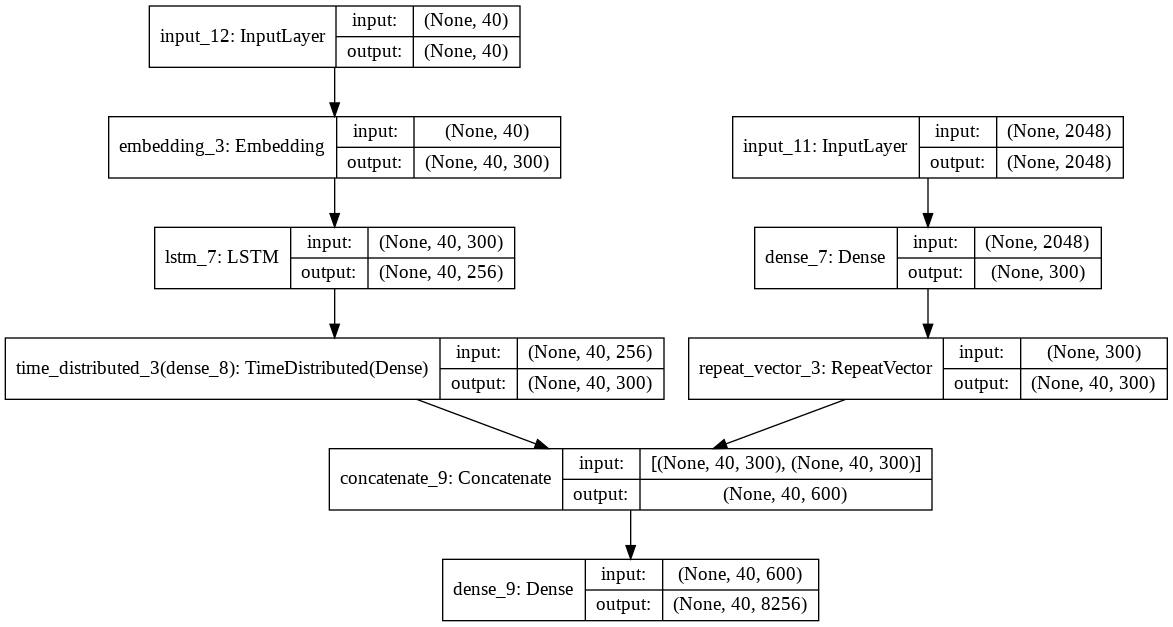

In [179]:
plot_model(final_model,show_shapes=True,show_layer_names=True)

In [156]:
final_model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

In [ ]:
samples_per_epoch = 0
for ca in caps:
    samples_per_epoch += len(ca.split())-1

In [ ]:
samples_per_epoch

In [ ]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1,verbose=1)

In [ ]:
final_model.save_weights('gdrive/My Drive/Image_Captioning/cap_gen/time_inceptionV3_1_loss_v3.h5')

In [157]:
final_model.load_weights('gdrive/My Drive/Image_Captioning/cap_gen/time_inceptionV3_1_loss_v2.h5')

In [158]:
def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word2idx[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        e = encoding_test[image[len(images):]]
        preds = final_model.predict([np.array([e]), np.array(par_caps)])
        word_pred = idx2word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])

In [159]:
def beam_search_predictions(image, beam_index = 3):
    start = [word2idx["<start>"]]
    
    start_word = [[start, 0.0]]
    
    while len(start_word[0][0]) < max_len:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_len, padding='post')
            e = encoding_test[image[len(images):]]
            preds = final_model.predict([np.array([e]), np.array(par_caps)])
            
            word_preds = np.argsort(preds[0])[-beam_index:]
            
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [idx2word[i] for i in start_word]

    final_caption = []
    
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [139]:
###Calculate Bleu Score
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

In [ ]:
bleu_df=pd.DataFrame(columns=['image_id','predicted_caption','bleu_1','bleu_2','bleu_3','bleu_4'])
m=0
for image_id in test_img:
  list_of_ref=[]
  # print("m : ",m)
  hypothesis_p=predict_captions(image_id)
  hypothesis_p=hypothesis_p.lower()
  references=test_d[image_id]
  for ref in references:
      ref=ref.lower()
      list_of_ref.append(ref.split())
  hypothesis=hypothesis_p.split()

  result_bleu_1 = sentence_bleu(list_of_ref, hypothesis,weights=(1, 0, 0, 0),smoothing_function=SmoothingFunction().method4)
  result_bleu_2 = sentence_bleu(list_of_ref, hypothesis,weights=(0.5, 0.5, 0, 0),smoothing_function=SmoothingFunction().method4)
  result_bleu_3 = sentence_bleu(list_of_ref, hypothesis,weights=(0.33, 0.33, 0.33, 0),smoothing_function=SmoothingFunction().method4)
  result_bleu_4 = sentence_bleu(list_of_ref, hypothesis,weights=(0.25, 0.25, 0.25, 0.25),smoothing_function=SmoothingFunction().method4)

  bleu_df.loc[m]=[image_id,hypothesis_p,result_bleu_1,result_bleu_2,result_bleu_3,result_bleu_4]
  m +=1

bleu_greedy=bleu_df

In [151]:
bleu_df.head()

image_id  ...    bleu_4
0  gdrive/My Drive/Image_Captioning/flickr8k/Flic...  ...  0.231443
1  gdrive/My Drive/Image_Captioning/flickr8k/Flic...  ...  0.314336
2  gdrive/My Drive/Image_Captioning/flickr8k/Flic...  ...  0.249358
3  gdrive/My Drive/Image_Captioning/flickr8k/Flic...  ...  0.467138
4  gdrive/My Drive/Image_Captioning/flickr8k/Flic...  ...  0.170260

[5 rows x 6 columns]

In [143]:
print("BlEU-1 :  ",bleu_df['bleu_1'].mean())
print("BlEU-2 :  ",bleu_df['bleu_2'].mean())
print("BlEU-3 :  ",bleu_df['bleu_3'].mean())
print("BlEU-4 :  ",bleu_df['bleu_4'].mean())

BlEU-1 :   0.5603367279810392
BlEU-2 :   0.37323850316037555
BlEU-3 :   0.31012388591853757
BlEU-4 :   0.2680731116575197


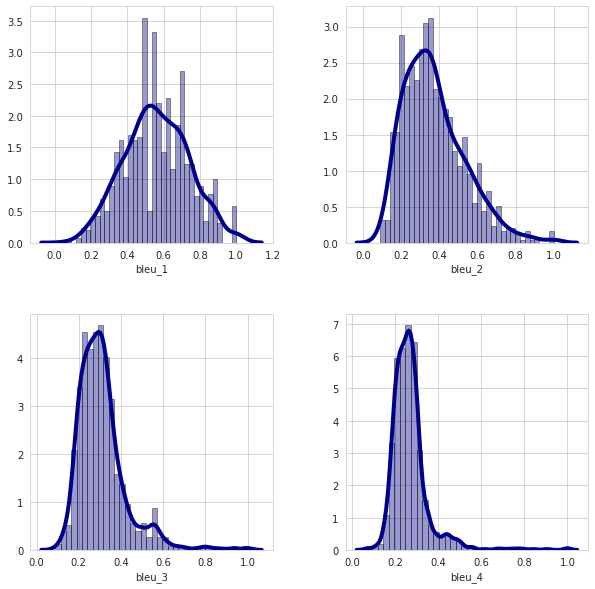

In [ ]:
import seaborn as sns
sns.set_style("whitegrid")
features=bleu_results.columns[2:]
count=0
fig, axes = plt.subplots(2, 2,figsize=(10,10))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
sns.distplot(bleu_results[features[0]], hist=True, kde=True,bins=int(180/5), color = 'darkblue', hist_kws={'edgecolor':'black'},kde_kws={'linewidth': 4},ax=axes[0, 0])
sns.distplot(bleu_results[features[1]], hist=True, kde=True,bins=int(180/5), color = 'darkblue', hist_kws={'edgecolor':'black'},kde_kws={'linewidth': 4},ax=axes[0, 1])
sns.distplot(bleu_results[features[2]], hist=True, kde=True,bins=int(180/5), color = 'darkblue', hist_kws={'edgecolor':'black'},kde_kws={'linewidth': 4},ax=axes[1, 0])
sns.distplot(bleu_results[features[3]], hist=True, kde=True,bins=int(180/5), color = 'darkblue', hist_kws={'edgecolor':'black'},kde_kws={'linewidth': 4},ax=axes[1, 1])
plt.show()

In [154]:
bleu_df.to_csv("gdrive/My Drive/Image_Captioning/cap_gen/merge_results.csv")

In [ ]:
print ('Normal Max search:', predict_captions(try_image)) 
print ('Beam Search, k=3:', beam_search_predictions(try_image, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(try_image, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(try_image, beam_index=7))


Normal Max search: A man in a red shirt and black pants is riding a bike on a hill .
Beam Search, k=3: A man rides a bike on a hill .
Beam Search, k=5: A man rides a bike on a rocky hill .
Beam Search, k=7: A man rides a bike on a hill .


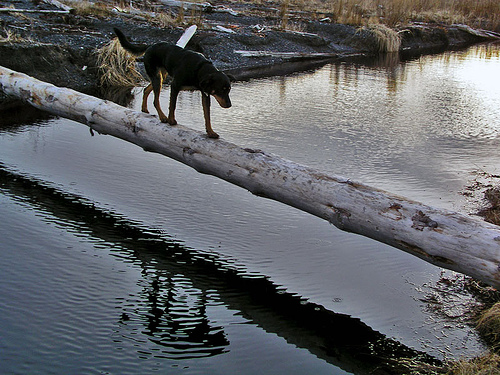

In [160]:
try_image = test_img[20]
Image.open(try_image)

In [161]:
print ('Normal Max search:', predict_captions(try_image)) 
print ('Beam Search, k=3:', beam_search_predictions(try_image, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(try_image, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(try_image, beam_index=7))

Normal Max search: A black dog is standing in the snow .
Beam Search, k=3: A black dog is standing in the snow .
Beam Search, k=5: A black dog is standing in the snow .
Beam Search, k=7: A black dog is in the snow .


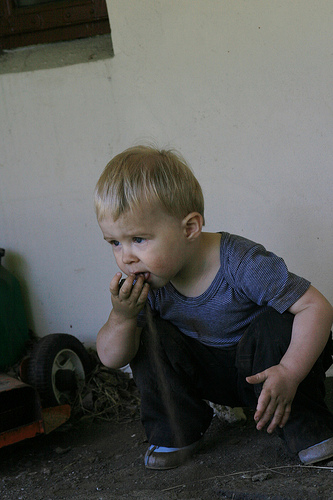

In [162]:
try_image = test_img[131]
Image.open(try_image)

In [163]:
print ('Normal Max search:', predict_captions(try_image)) 
print ('Beam Search, k=3:', beam_search_predictions(try_image, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(try_image, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(try_image, beam_index=7))

Normal Max search: A man with a black shirt and black pants is sitting on a concrete wall .
Beam Search, k=3: A man in a yellow shirt is sitting on a concrete wall .
Beam Search, k=5: A man in a blue shirt is sitting on a wooden bench .
Beam Search, k=7: A little boy in a yellow shirt is sitting on a concrete wall .


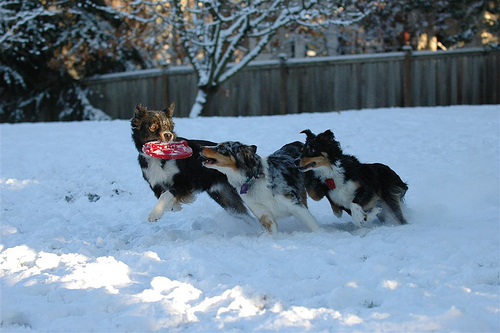

In [164]:
try_image = test_img[558]
Image.open(try_image)

In [165]:
print ('Normal Max search:', predict_captions(try_image)) 
print ('Beam Search, k=3:', beam_search_predictions(try_image, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(try_image, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(try_image, beam_index=7))

Normal Max search: Two dogs are running through the snow .
Beam Search, k=3: Two dogs are running in the snow .
Beam Search, k=5: Two dogs play in the snow .
Beam Search, k=7: Two dogs play in the snow .


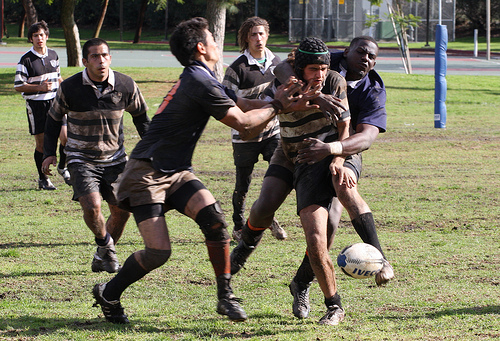

In [166]:
try_image = test_img[225]
Image.open(try_image)

In [167]:
print ('Normal Max search:', predict_captions(try_image)) 
print ('Beam Search, k=3:', beam_search_predictions(try_image, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(try_image, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(try_image, beam_index=7))

Normal Max search: A man and two dogs are in a field .
Beam Search, k=3: A group of people are in a field .
Beam Search, k=5: A group of people are in a field .
Beam Search, k=7: A group of people are in a field .


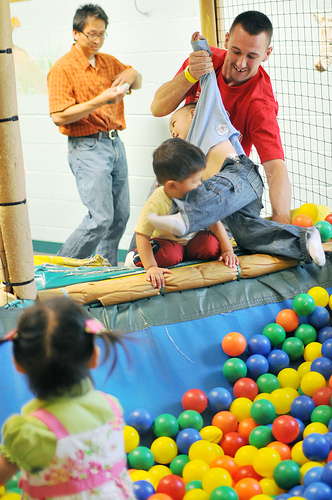

In [168]:
try_image = test_img[570]
Image.open(try_image)

In [169]:
print ('Normal Max search:', predict_captions(try_image)) 
print ('Beam Search, k=3:', beam_search_predictions(try_image, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(try_image, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(try_image, beam_index=7))

Normal Max search: A boy is standing on a yellow slide .
Beam Search, k=3: A boy in a blue shirt is standing in a red and white pool .
Beam Search, k=5: A boy in a blue shirt is standing in a yellow and white toy .
Beam Search, k=7: A little boy in a blue shirt is looking at a little boy .


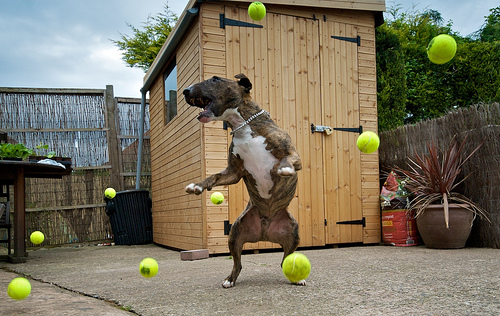

In [170]:
try_image = test_img[120]
Image.open(try_image)

In [171]:
print ('Normal Max search:', predict_captions(try_image)) 
print ('Beam Search, k=3:', beam_search_predictions(try_image, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(try_image, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(try_image, beam_index=7))

Normal Max search: A brown dog is playing with a tennis ball in a grassy field .
Beam Search, k=3: A brown dog jumping to catch a tennis ball .
Beam Search, k=5: A brown dog jumping to catch a tennis ball .
Beam Search, k=7: .


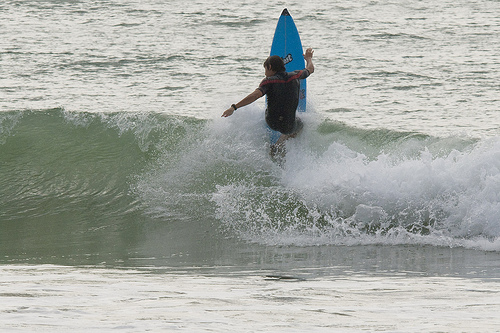

In [172]:
try_image = test_img[9]
Image.open(try_image)

In [173]:
print ('Normal Max search:', predict_captions(try_image)) 
print ('Beam Search, k=3:', beam_search_predictions(try_image, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(try_image, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(try_image, beam_index=7))

Normal Max search: A man is standing on a beach on his surfboard .
Beam Search, k=3: A man in a black wetsuit is standing on a beach .
Beam Search, k=5: A man in a black wetsuit is standing in the ocean .
Beam Search, k=7: A man in a black wetsuit is standing in the ocean .


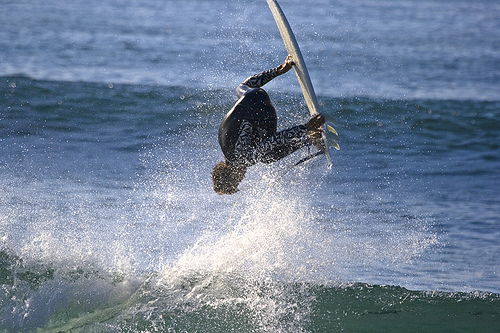

In [174]:
try_image = test_img[17]
Image.open(try_image)

In [175]:
print ('Normal Max search:', predict_captions(try_image)) 
print ('Beam Search, k=3:', beam_search_predictions(try_image, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(try_image, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(try_image, beam_index=7))

Normal Max search: A man is surfing on a wave .
Beam Search, k=3: A surfer rides a wave .
Beam Search, k=5: A surfer rides a wave .
Beam Search, k=7: A surfer rides a wave .
